Use python 3.10 in google colab

In [1]:
!wget https://github.com/korakot/kora/releases/download/v0.10/py310.sh
!bash ./py310.sh -b -f -p /usr/local
!python -m ipykernel install --name "py310" --user

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


???????? Windows ?????? BIOS ???????

???????? https://aka.ms/wsl2-install

Installed kernelspec py310 in C:\Users\David\AppData\Roaming\jupyter\kernels\py310


In [2]:
import copy

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from typing import Union
from torch.utils.data import Subset
import time
from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SRC: datasets



In [3]:
import os
import torchaudio

def get_dataset(dataset_name, url = None, subset = None):
    """
    Retrieves a dataset and downloads it locally if needed.
        
    Inputs
    ------
    dataset_name : str
        Name of the dataset to download. Allowed dataset names: "librispeech", "librilightlimited", "tedlium"
    
    url : (str, optional)
        Optional argument for some datasets 
    
    subset : (str, optional)
        Optional argument for some datasets 
    
    Returns
    -------
    dataset :
        A torchaudio.dataset
    
    """
    _SAMPLE_DIR = "_assets"
    dataset_name = dataset_name.lower()
    dataset_path = os.path.join(_SAMPLE_DIR, dataset_name)
    os.makedirs(dataset_path, exist_ok=True)
        
    if dataset_name == "librispeech":
        url = url if url else "dev-clean"
        print(f"You're about to download librispeech with url {url}")
        dataset = torchaudio.datasets.LIBRISPEECH(dataset_path, download=True, url=url)
    
    elif dataset_name == "librilightlimited":
        subset = subset if subset else "10min"
        print(f"You're about to download librispeech with subset {subset}")
        dataset = torchaudio.datasets.LibriLightLimited(dataset_path, download=True, subset=subset)
        
    elif dataset_name == "tedlium":
        subset = subset if subset else "train"
        print(f"You're about to download Tedlium with subset {subset}")
        dataset = torchaudio.datasets.TEDLIUM(dataset_path, download=True, subset=subset)
    
    else:
        raise ValueError(f"The dataset you passed '{dataset_name}' is not in the list of datasets")
    
    print("\n Done downloading")
    return dataset 

## SRC: Visualization



In [4]:
#import os
from random import randint

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
#import torchaudio
from IPython.display import Audio, display


#Get a random video clip from dataset
def get_random_sample(dataset):
    """
    Takes a random sample in the dataset and return its waveform and sample rate
    """
    dataset_length = dataset.__len__()
    # get a random sample in the dataset
    sample_id = randint(0, dataset_length)
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(sample_id)
    
    return waveform, sample_rate
    
def plot_mfccs(waveform, sample_rate):
    wv_processed = waveform.numpy().flatten()
    mfccs = librosa.feature.mfcc(y=wv_processed, n_mfcc=13, sr=sample_rate)
    plt.figure(figsize=(15, 8))
    librosa.display.specshow(mfccs, x_axis="time", sr=sample_rate)
    #plt.colorbar(format="%+2.f")
    plt.show()
    
    
    
def play_audio(waveform : torch.Tensor, sample_rate : int) -> None:
    """
    Plays audio given a waveform and sample rate
    
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")
        
def plot_specgram(waveform : torch.Tensor, sample_rate : int , title : str ="Spectrogram", xlim=None) -> None:
    """
    Plots a spectogram of audio given a waveform and sample rate
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_waveform(waveform, sample_rate, title = "Waveform", xlim = None, ylim = None):
    """
    Plots the waveform of an audio sample
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)
    
def visualize_random_sample(dataset, play_waveform = True, plot_wave = False, plot_spectogram = False):
    """
    Takes a random sample in the dataset and displays relevant metrics
    """
    dataset_length = dataset.__len__()
    # get a random sample in the dataset
    sample_id = randint(0, dataset_length)
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(sample_id)
    print('waveform: ', waveform)
    print('sample_rate: ', sample_rate)
    print('transcript: ', transcript)
    print('speaker_id: ', speaker_id)
    
    if play_waveform:
        play_audio(waveform, sample_rate)
        
    if plot_wave:
        plot_waveform(waveform, sample_rate)
    
    if plot_spectogram:
        plot_specgram(waveform, sample_rate, title=f"Sample {sample_id}, Speaker_id {speaker_id}")
        
def calculate_statistics(dataset) -> pd.DataFrame:
    """
    Calculates and plots statistics about the dataset
    
    Inputs
    ------
    dataset :
        The dataset to calculate statistics for
        
    verbose : bool
        If true, it will print the statistics
        
    Returns
    -------
    df_info : pd.DataFrame
        A dataframe with statistics about the dataset. Can be used to make your own statistics
    """
    print(f"Dataset has {dataset.__len__()} samples")
    print(f"Random samples has shape: {dataset.__getitem__(0)[0].shape}")
    
    waveform_lengths = []
    sample_rates = []
    transcript_lengths = []
    speaker_ids = []
    audio_durations = []    
    
    for i in range(dataset.__len__()):
        (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
        waveform_lengths.append(waveform[0].shape[0])
        sample_rates.append(sample_rate)
        transcript_lengths.append(len(transcript))
        speaker_ids.append(speaker_id)
        
        num_channels, num_frames = waveform.shape
        duration = num_frames / sample_rate
        audio_durations.append(duration)
        
    dataset_stats = pd.DataFrame.from_dict(
    {
        "waveform_lengths" : waveform_lengths,
        "sample_rates" : sample_rates,
        "transcript_lengths" : transcript_lengths,
        "audio_durations" : audio_durations,
    }
    )
    
    print(f"Unique speaker ids: {len(np.unique(speaker_ids))}")
    display(dataset_stats.describe().loc[["min","std","min","max"]].round())
    print("\n")
    
    # plotting:
    fig, ax = plt.subplots(1, dataset_stats.shape[1], figsize=(12, 6))
    for i, col in enumerate(dataset_stats.columns):
        ax[i].boxplot(dataset_stats[col])
        ax[i].set_title(col)
    plt.tight_layout()
    
    plt.figure(figsize=(6, 6))
    plt.scatter(dataset_stats["waveform_lengths"], dataset_stats["transcript_lengths"])
    plt.xlabel("waveform_lengths")
    plt.ylabel("transcript_lengths")
    
    return dataset_stats

## SRC: Audio_utils





In [5]:
from typing import Union

import numpy as np
import numpy.typing as npt
import pandas as pd
from tqdm import tqdm


def split_waveform(waveform, window_size):
    """
    Takes an original waveform and reduce to chunks of smaller intervals using a sliding window
    
    waveform : nd.array
    
    window_size : int
        window size in seconds
    
    Returns
    -------
    splitted_waveform : list[nd.array]
        list of waveforms
    
    """
    splitted_waveform = []
    
    for i in range(0, len(waveform), window_size):
        split = waveform[i:i+window_size]
        if len(split) == window_size:
            splitted_waveform.append(split)

    return splitted_waveform

class CepstralNormalization:
    def __init__(self, number_spectral_coefficients : int):
        """
        Class for Cepstral Normalization. Cepstral normalization performs normalization
        by channels/coefficients
        """
        self.number_spectral_coefficients = number_spectral_coefficients
        self.mfcc_mean : list[float] = []
        self.mfcc_std : list[float] = []
    
    def fit(self, mfcc_ids, mfcc_channel_db):
        """
        Calculates the mean and standard deviation of each channel of the MFCCs
        
        Inputs
        ------
        mfcc_ids : list[int]
            list of the mfcc ids to use for fitting

        mfcc_channel_db : pd.DataFrame
            A dataframe of the following shape

                    channel_1 | channel 2 | channel 3 | ...
            mfcc_id

        Returns
        -------
        mfcc_mean : list[float]
            A list with the mean value of each channel
        
        mfcc_std : list[float]
            A list with the standard deviation value of each channel

        """
        mfcc_mean = []
        mfcc_std = []
        
        print('Normalizing...')
        for channel in tqdm(range(self.number_spectral_coefficients)):
            channel_data = mfcc_channel_db.loc[mfcc_ids][f"channel_{channel}"].values
            channel_data_list = []
            for x in channel_data:
                channel_data_list.extend(x.flatten().tolist())
            
            mfcc_mean.append(np.mean(channel_data_list))
            mfcc_std.append(np.std(channel_data_list))

        self.mfcc_mean, self.mfcc_std = mfcc_mean, mfcc_std
        
        return self.mfcc_mean, self.mfcc_std
    
    def transform(self, mfcc_ids, mfcc_channel_db):
        """
        Normalizes MFCCs

        Inputs
        ------
        mfcc_ids : list[int]
            list of the mfcc ids to normalize

        mfcc_channel_db : pd.DataFrame
            A dataframe of the following shape

                    channel_1 | channel 2 | channel 3 | ...
            mfcc_id

        Returns
        -------
        mfcc_channel_db : pd.DataFrame
            normalized dataframe

        """                
        normalized_mfcc_channel_db = pd.DataFrame(data=mfcc_ids, columns=['mfcc_id']).set_index('mfcc_id')

        for channel in range(self.number_spectral_coefficients):
            channel_data = mfcc_channel_db.loc[mfcc_ids][f"channel_{channel}"].values
            channel_data = (channel_data - self.mfcc_mean[channel]) / self.mfcc_std[channel]
            normalized_mfcc_channel_db[f"channel_{channel}"] = channel_data
            
        return normalized_mfcc_channel_db

    def inverse_transform(self):
        #TODO
        raise NotImplementedError

## Problem Definition: Speaker Classification

Our project consists of identifying a speaker based on recorded audio samples. The model is trained from multiple audio samples for many speakers. Given a new audio sample, the model should identify which of the speakers it belongs to.  

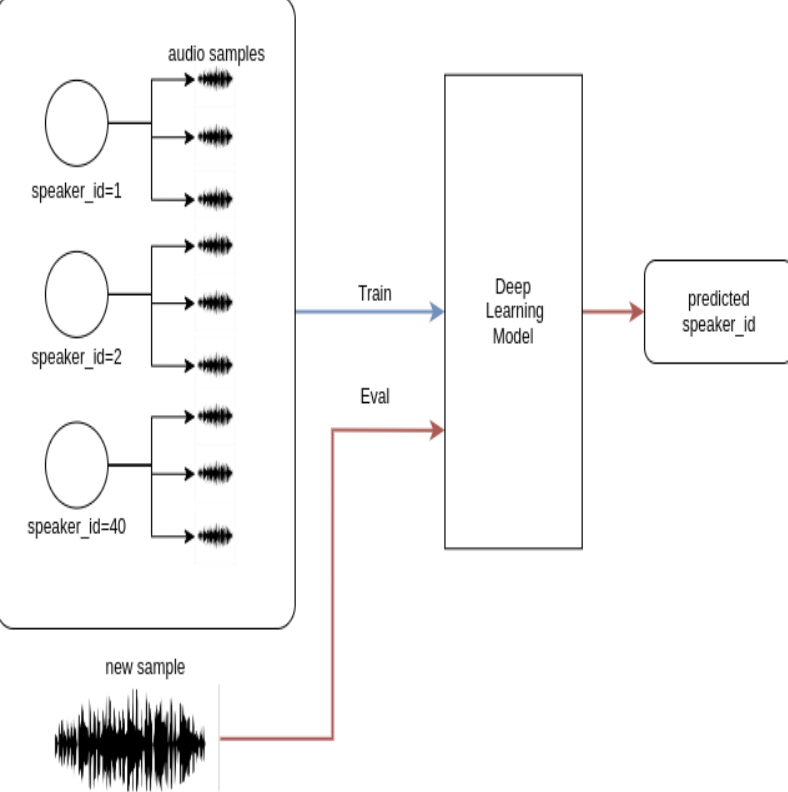

## Dataset
There are multiple datasets that include speaker_id and audio samples. Up to this point, we decided to start with Librispeech as it provides hours of recorded audio samples in relatively noise-free environments. 

LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

There are multiple sizes of the dataset. In this notebook we are using **dev-clean** which is the development dataset. In other notebooks, we will use a version with more samples 

In [6]:
dataset_name = "librispeech"
url = 'train-clean-100'
dataset = get_dataset(dataset_name, url=url)

You're about to download librispeech with url train-clean-100

 Done downloading


# Data Visualization

The data extract from librispeech includes audio samples recorded as waveforms. In audio processing algorithm, it is standard practice to extract data by transforming the waveforms into a spectrogram or a varation of a spectrogram called a Mel-frequency cepstrum (MFC). This is done to remove unnecessary data from the waveforms and keep important information such as time, frequency, and amplitude.   

Visualizing data in random sample from the dataset

waveform:  tensor([[0.0000, 0.0020, 0.0026,  ..., 0.0008, 0.0010, 0.0004]])
sample_rate:  16000
transcript:  AND AFTER ALL THAT RACING AND FEE TO THE COACHMAN AND ALL I SPOKE TO BOTH THE PORTER AND THE PORTRESS A FINE STOUT WOMAN AND THEY KNOW NOTHING ABOUT HIM MARIUS BREATHED FREELY ONCE MORE
speaker_id:  83


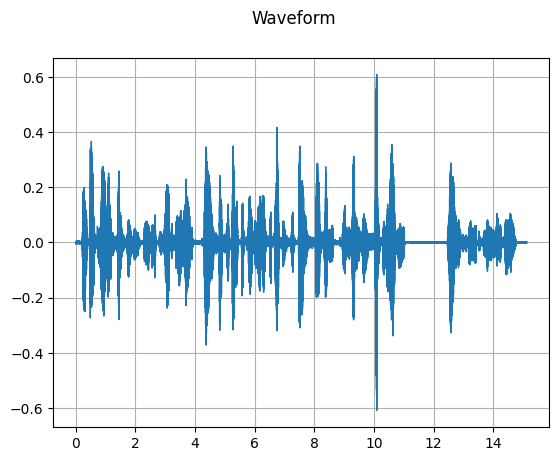

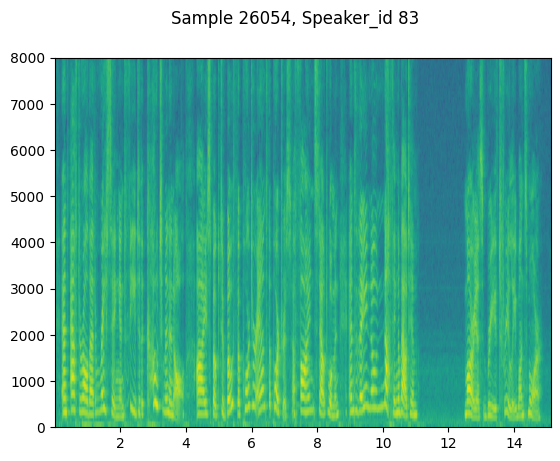

In [7]:
visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

#### Calculate statistics in dataset

In [15]:
waveform_lengths = []
sample_rates = []
transcript_lengths = []
speaker_ids = []
audio_durations = []
waveforms = []
transcripts = []

for i in tqdm(range(dataset.__len__())):
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
    speaker_ids.append(speaker_id)

    waveform_lengths.append(waveform[0].shape[0])
    sample_rates.append(sample_rate)
    transcript_lengths.append(len(transcript))
    waveforms.append(waveform[0].numpy())
    transcripts.append(transcript)
    num_channels, num_frames = waveform.shape
    duration = num_frames / sample_rate
    audio_durations.append(duration)

dataset_stats = pd.DataFrame.from_dict(
{
    "waveform_lengths" : waveform_lengths,
    "sample_rates" : sample_rates,
    "transcript_lengths" : transcript_lengths,
    "audio_durations" : audio_durations,
}
    )

100%|██████████| 28539/28539 [03:06<00:00, 152.66it/s]


Dataset has 28539 samples
Random samples has shape: torch.Size([1, 225360])
Unique speaker ids: 251


waveform_lengths  sample_rates  transcript_lengths  audio_durations
min           22560.0       16000.0                 8.0              1.0
std           57194.0           0.0                59.0              4.0
min           22560.0       16000.0                 8.0              1.0
max          392400.0       16000.0               398.0             25.0

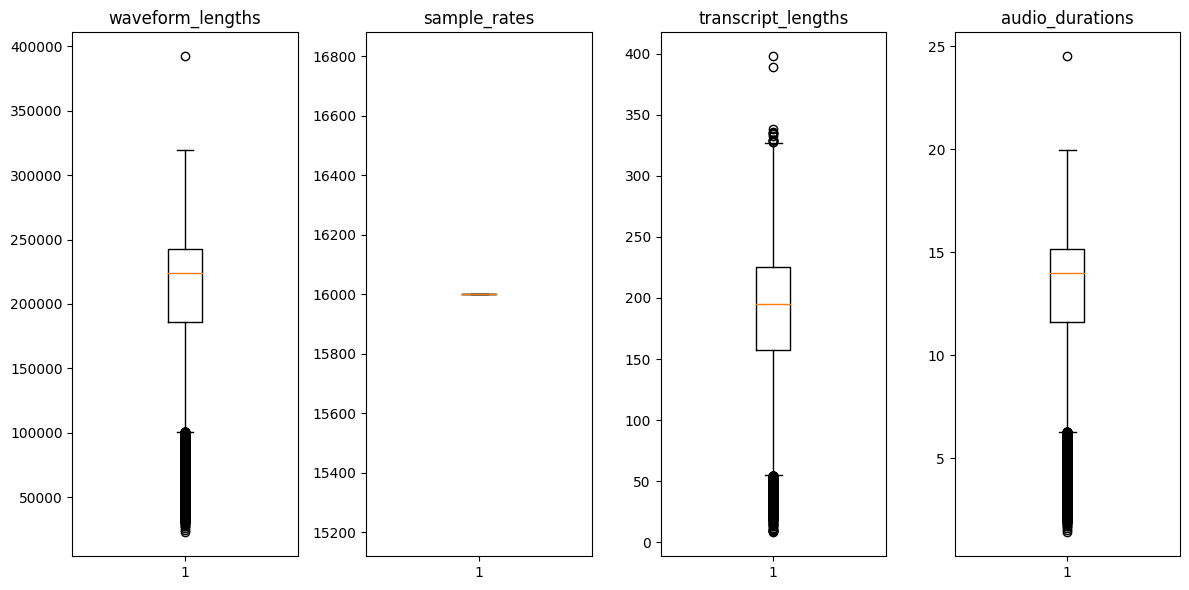

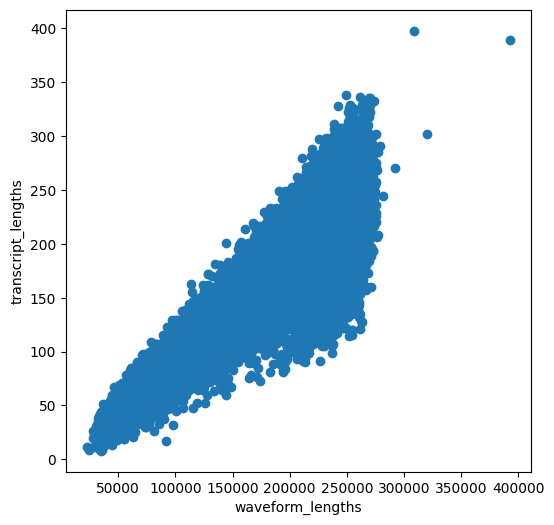

In [16]:
df = calculate_statistics(dataset)

We can see from the above charts that there is a lot of variance in the audio duration. Our model needs to take consistent sizes of audio.

In [17]:
df_spkr = pd.DataFrame(columns=['speaker_id', 'duration'])
df_spkr['speaker_id'] = speaker_ids
df_spkr['duration'] = audio_durations

In [18]:
#df_spkr.to_csv('df_speaker_ids.csv')
df_spkr = pd.read_csv('df_speaker_ids.csv')

In [19]:
df_spkr.groupby('speaker_id').mean().sort_values(by='duration', ascending=True)

Unnamed: 0   duration
speaker_id                       
27              7391.5   8.756087
1183            1016.5   8.832955
211             5090.5   9.115632
4014           12577.0   9.164455
730            23220.0   9.388261
...                ...        ...
412            13299.0  14.137790
7517           24081.0  14.148641
2092            4954.5  14.206226
8312           26264.5  14.231651
7794           24413.5  14.279811

[251 rows x 2 columns]

Because on average the duration of each speaker is 4.8 or higher, we decided to use a window_size of 4 seconds. Samples shorter than 4 seconds will be removed from the dataset.

Number of samples for each speaker

In [20]:
df_spkr.groupby('speaker_id').size().sort_values()

speaker_id
7312     26
1992     56
445      60
1183     66
8014     76
       ... 
2989    155
8063    155
730     161
4014    165
211     166
Length: 251, dtype: int64

We can see than in this dataset, some speakers have 36 samples only. This could potentially be little data to train a model. 

Unique speaker ids

In [21]:
np.unique(df_spkr['speaker_id'])

array([  19,   26,   27,   32,   39,   40,   60,   78,   83,   87,   89,
        103,  118,  125,  150,  163,  196,  198,  200,  201,  211,  226,
        229,  233,  248,  250,  254,  289,  298,  302,  307,  311,  322,
        328,  332,  374,  403,  405,  412,  426,  441,  445,  446,  458,
        460,  481,  587,  625,  669,  696,  730,  831,  839,  887,  909,
        911, 1034, 1040, 1069, 1081, 1088, 1098, 1116, 1183, 1235, 1246,
       1263, 1334, 1355, 1363, 1447, 1455, 1502, 1553, 1578, 1594, 1624,
       1723, 1737, 1743, 1841, 1867, 1898, 1926, 1963, 1970, 1992, 2002,
       2007, 2092, 2136, 2159, 2182, 2196, 2289, 2384, 2391, 2416, 2436,
       2514, 2518, 2691, 2764, 2817, 2836, 2843, 2893, 2910, 2911, 2952,
       2989, 3112, 3168, 3214, 3235, 3240, 3242, 3259, 3374, 3436, 3440,
       3486, 3526, 3607, 3664, 3699, 3723, 3807, 3830, 3857, 3879, 3947,
       3982, 3983, 4014, 4018, 4051, 4088, 4137, 4160, 4195, 4214, 4267,
       4297, 4340, 4362, 4397, 4406, 4441, 4481, 46

Visualize spectrograms

In [22]:
df_speaker_waveform = pd.DataFrame(columns=['speaker_id', 'waveform', 'transcript'])
df_speaker_waveform['speaker_id'] = speaker_ids
df_speaker_waveform['waveform'] = waveforms
df_speaker_waveform['transcript'] = transcripts

In [23]:
df_speaker_waveform[df_speaker_waveform['speaker_id']==84].head()

Empty DataFrame
Columns: [speaker_id, waveform, transcript]
Index: []

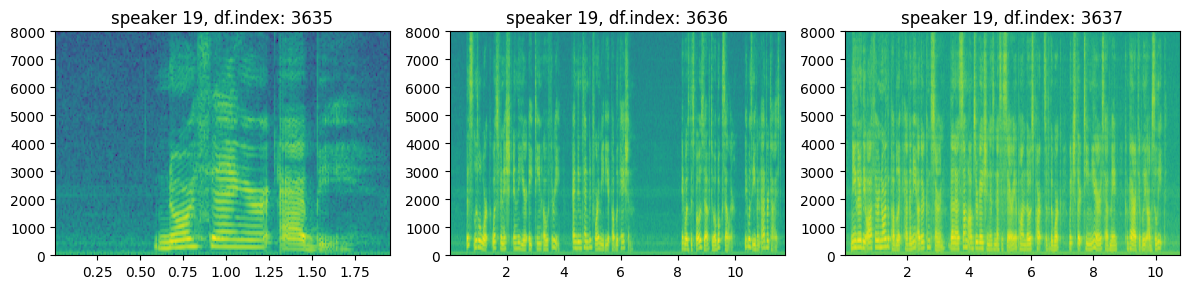

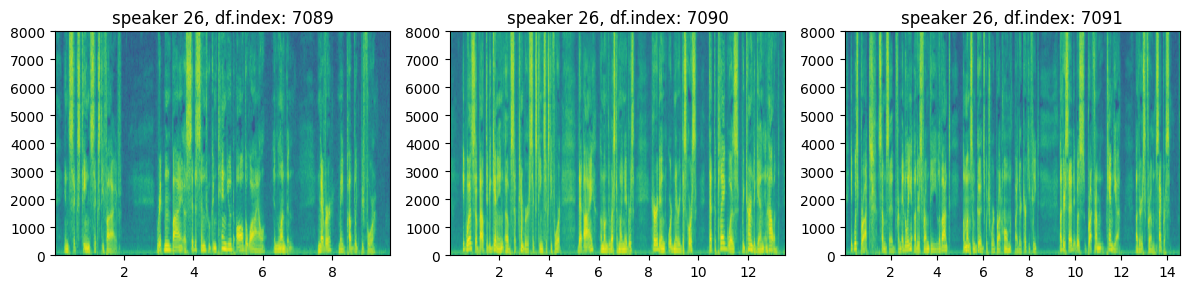

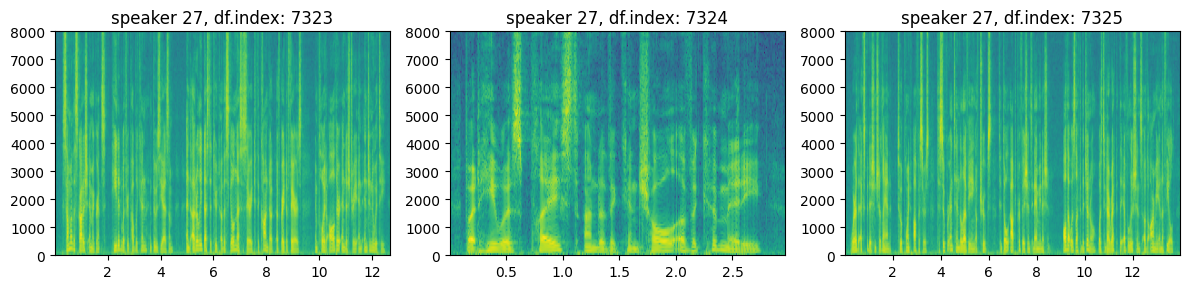

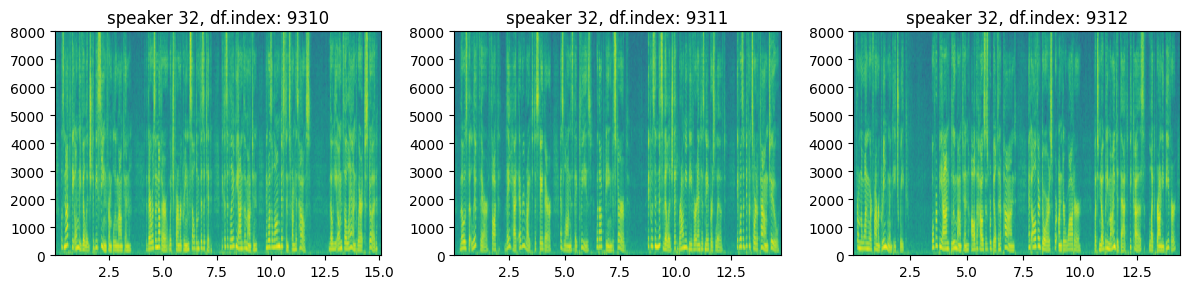

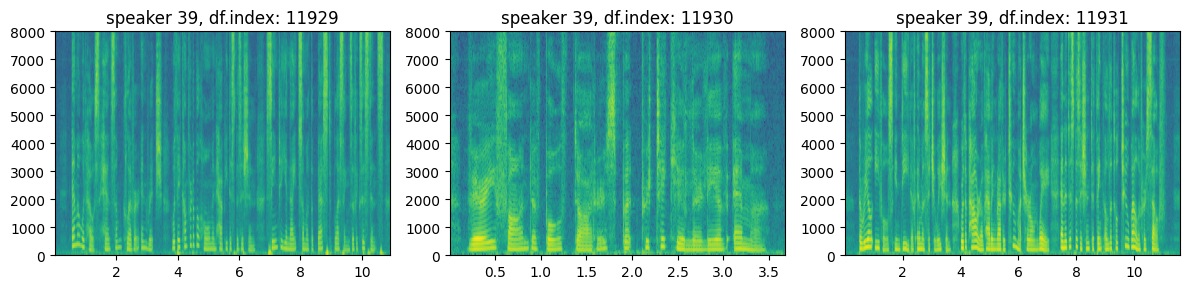

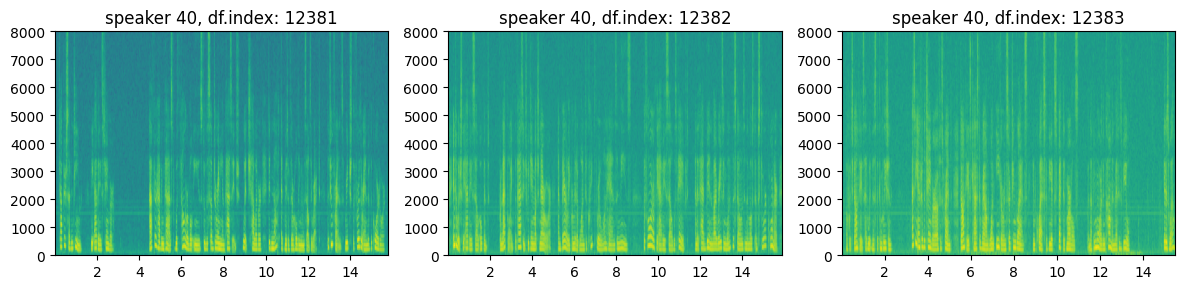

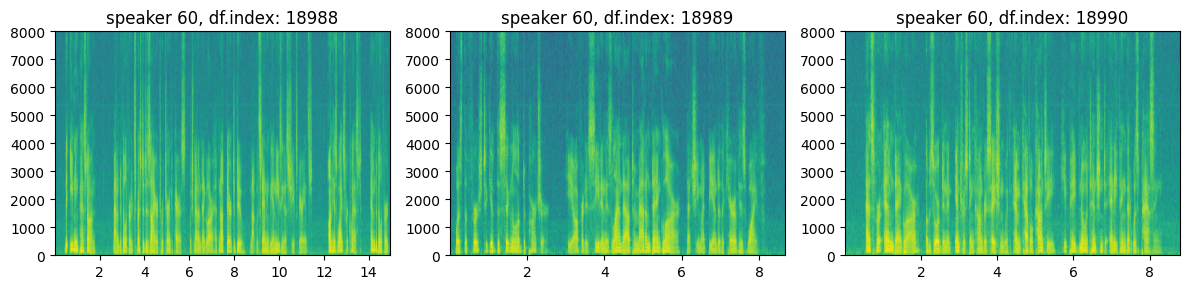

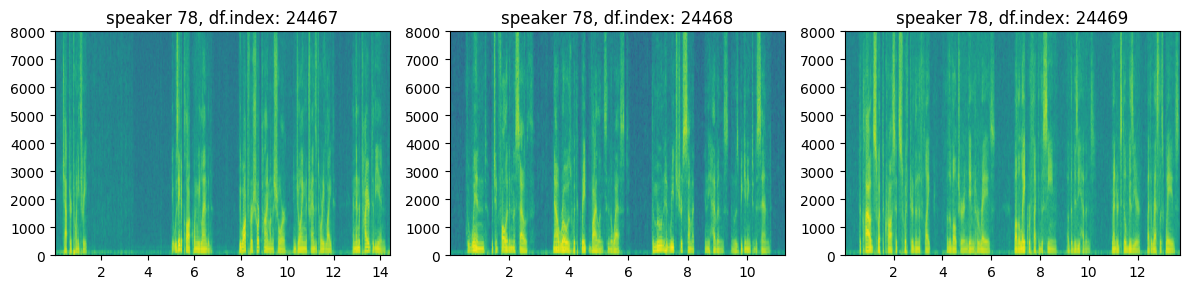

In [24]:
num_cols = 3
for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
    fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
    waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
    idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
    for j, wave in enumerate(waves[:num_cols]):
        ax[j].specgram(wave, Fs=sample_rate)
        ax[j].set_title(f'speaker {speaker_id}, df.index: {idx[j]}')

        plt.tight_layout()

Visualize MFCC spectrograms

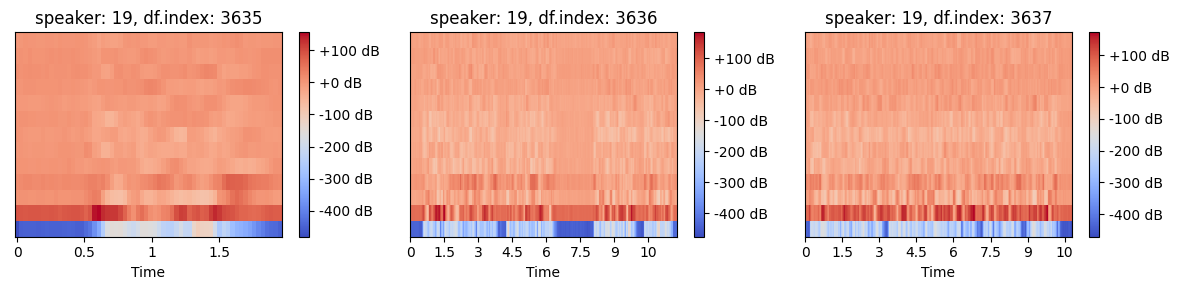

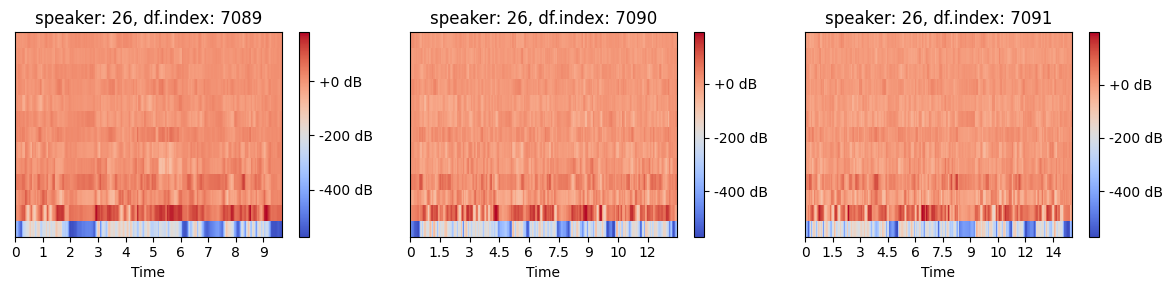

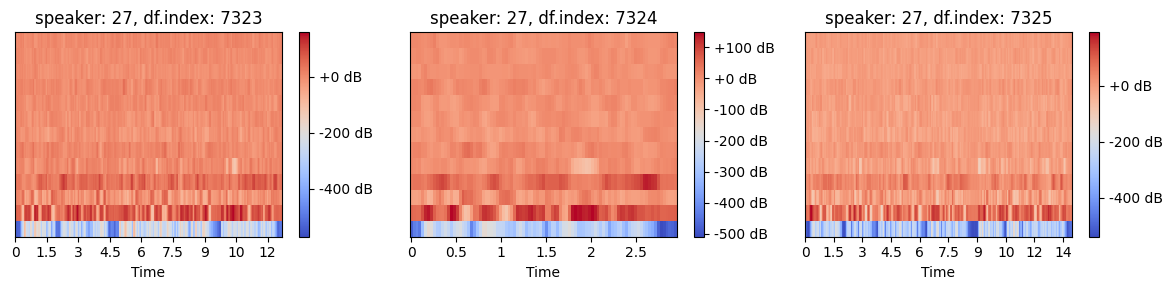

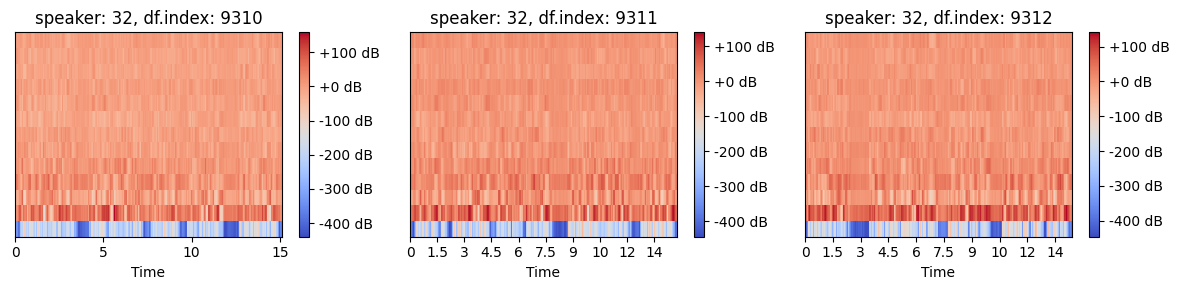

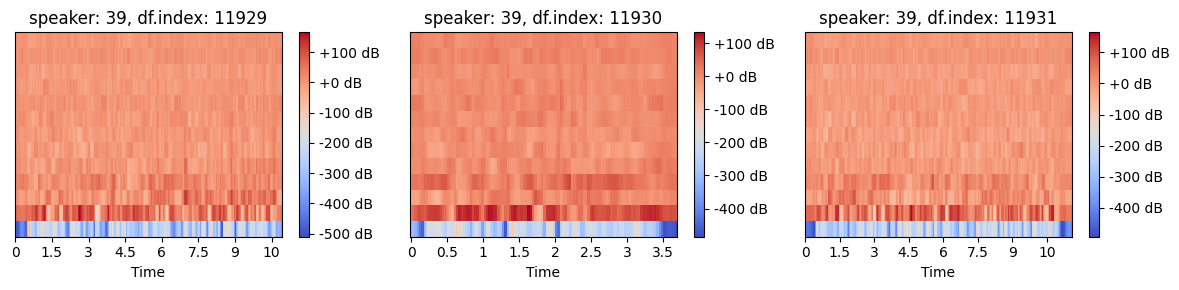

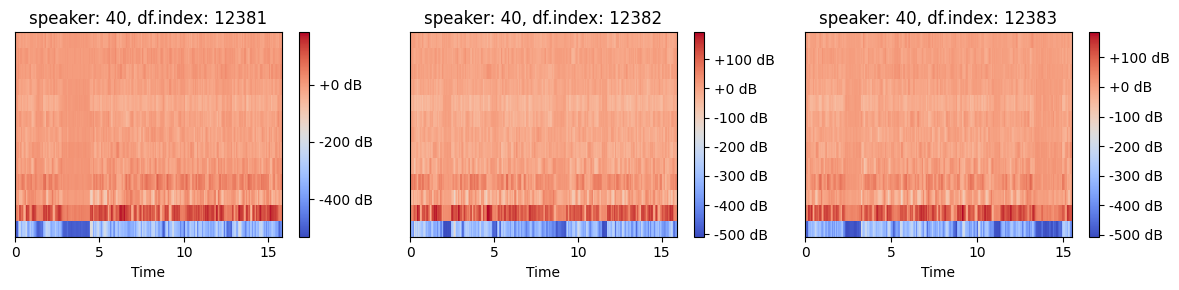

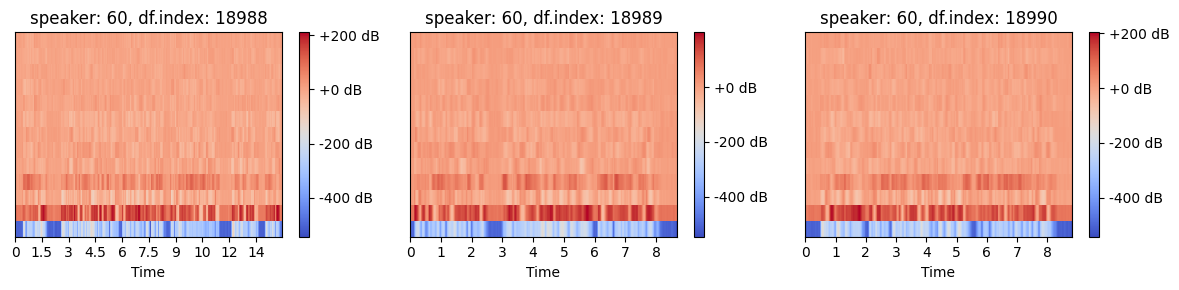

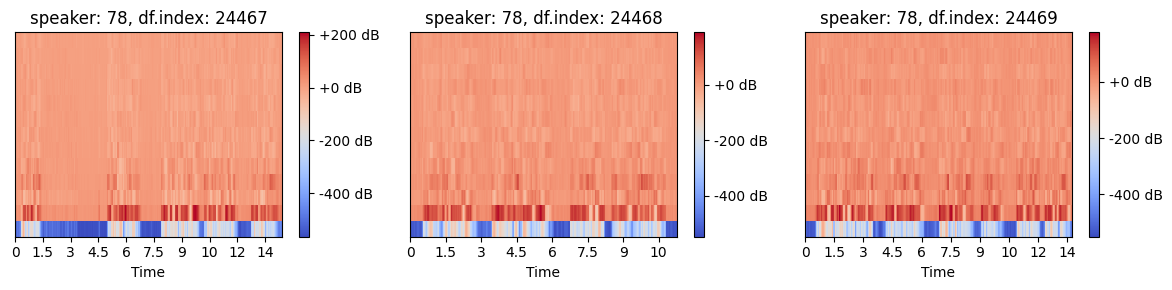

In [25]:
num_cols = 3
for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
    fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
    waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
    idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
    for j, wave in enumerate(waves[:num_cols]):
        mfccs = librosa.feature.mfcc(y=wave.flatten(), n_mfcc=13, sr=sample_rate)
        img = librosa.display.specshow(mfccs, x_axis="time", sr=sample_rate, ax=ax[j])
        ax[j].set_title(f'speaker: {speaker_id}, df.index: {idx[j]}')
        fig.colorbar(img, ax=ax[j], format="%+2.f dB")
    plt.tight_layout()

Visualization of each channel in MFCC

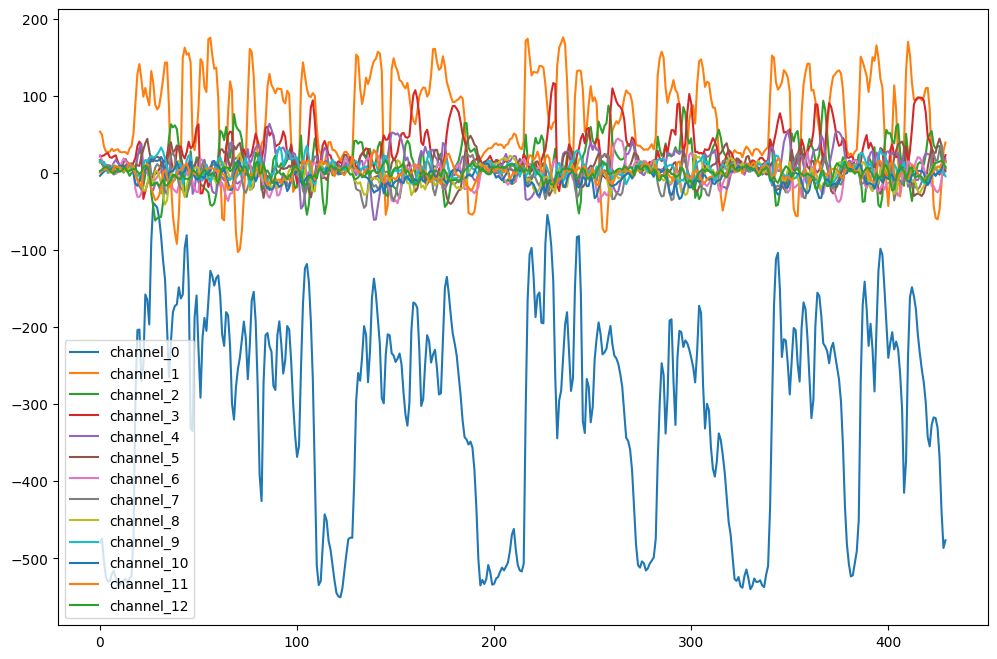

In [19]:
plt.figure(figsize=(12, 8))
for i in range(mfccs.shape[0]):
    plt.plot(mfccs[i,:], label=f"channel_{i}")
plt.legend()

## Preprocessing

<center><img src="images/preprocessing.png" height="400"></center>

The preprocessing pipeline consists of the following steps:
1. Transform waveforms to MFCC
2. (optional) Perform Cepstral Normalization on the MFCC
3. Transform MFCC (2D-array) to a greyscale image

**Cepstral normalization** is the process of normalizing the MFCCs at every channel. The first channels of the MFCC carry the most important features; therefore, channels should not be mixed during normalization. At every channel, the values are normalized by subtracting the mean and dividing by the standard deviation: 
$$(X_{channel} - \mu_{channel})/\sigma_{channel} $$

Special consideration had to be taken during splitting of the data into train, validation, and test as well as during normalization. 

1. To ensure that each speaker_id is represent in each set, before splitting the audio samples were grouped by speaker id. Then the samples in each speaker_id are splitted in x% train, y% validation, z% test

2. To ensure there is no data leakage between training and other sets during normalization, **the Cepstral Normalizer only uses MFCCs from the training set during fitting.**

In [26]:
class MFCCData(Dataset):
    def __init__(self, speaker_mfcc_db, mfcc_channel_db, transform=None):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        Inputs
        ------
        speaker_mfcc_db : pd.DataFrame
            dataframe of (index, speaker_id, mfcc_id)
            
        mfcc_channel_db : pd.DataFrame
            dataframe of (mfcc_id, channel_1, channel_2, ...)
            
        transform : optional 
            transformations to perform on the MFCCs
        """
        self.speaker_mfcc_db = speaker_mfcc_db
        self.mfcc_channel_db = mfcc_channel_db        
        self.transform = transform
            
    def __len__(self):
        return len(self.speaker_mfcc_db)

    def __getitem__(self, idx):
        speaker_id = self.speaker_mfcc_db.iloc[idx]['speaker_id']
        mfcc_id = self.speaker_mfcc_db.iloc[idx]['mfcc_id']
        
        mfcc = []
        for i, col in enumerate(self.mfcc_channel_db.columns):
            mfcc_channel_i = self.mfcc_channel_db.loc[mfcc_id, f'channel_{i}']
            mfcc.append(mfcc_channel_i)
            
        mfcc = np.asarray(mfcc)
        mfcc = mfcc.reshape(len(self.mfcc_channel_db.columns), -1)
        
        if self.transform:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            mfcc = np.transpose(mfcc, [1, 2, 0])
            mfcc = self.transform(mfcc)
            
        else:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            
        speaker_id = torch.tensor(speaker_id) 
        mfcc = torch.tensor(mfcc) 
            
        if torch.cuda.is_available():
            speaker_id = speaker_id.to('cuda')
            mfcc = mfcc.to('cuda')
            
        return mfcc, speaker_id

In [27]:
def speaker_encoder(speaker_ids):
    """
    Creates a dictionary of (speaker_id, encoded_id) pairs
    """
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
    return speaker_dict

In [28]:
def create_mfcc_databases(dataset, window_size, sample_rate, speaker_dict, number_spectral_coefficients):
    """
    Creates two databases from an audio dataset e.g. librispeech
    
    Inputs
    -----
    
    base_dataset : 
        A pytorch audio dataset like librispeech
    
    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz    
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    Returns
    -------
    speaker_mfcc_db : pd.DataFrame 
        df with shape (index_id, speaker_id, mfcc_id)
    
    mfcc_channel_db : pd.DataFrame
        df with shape (mfcc_id, channel_id)
    
    """
    try:
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
    
    except FileNotFoundError:
        speaker_mfcc_db = pd.DataFrame(columns=["speaker_id", "mfcc_id"])
        mfcc_channel_db = pd.DataFrame(columns=["mfcc_id"]+[f"channel_{i}" for i in range(number_spectral_coefficients)]).set_index('mfcc_id')

        idx = 0

        print('Creating a database. Hold tight...')
        for i in tqdm(range(dataset.__len__())):
            (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
            waveform_arr = waveform.numpy().flatten()
            splitted_waveform = split_waveform(waveform_arr, window_size) # split waveforms into consistent chunks

            for chunk in splitted_waveform: # transform waveforms into MFCC spectrograms
                mfccs = librosa.feature.mfcc(y=chunk.flatten(), n_mfcc=13, sr=sample_rate)

                speaker_mfcc_db.loc[idx, "speaker_id"] = speaker_dict[speaker_id]
                speaker_mfcc_db.loc[idx, "mfcc_id"] = idx

                for j in range(number_spectral_coefficients):
                    mfcc_channel_db.loc[idx, f"channel_{j}"] = 1
                    mfcc_channel_db.at[idx, f"channel_{j}"] = mfccs[j, :]
                
                idx += 1

        speaker_mfcc_db.to_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db.to_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')

    return speaker_mfcc_db, mfcc_channel_db

In [29]:
def split_train_test_val(speaker_mfcc_db, train_pct, val_pct, 
                         test_pct):
    """
    Splits the dataset into train, validation, and test. This function returns the indices of the dataframe corresponding
    to each set
    """
    train_ids = []
    val_ids = []
    test_ids = []
    
    for speaker_id in np.unique(speaker_mfcc_db["speaker_id"].values):
        mfcc_ids = speaker_mfcc_db[speaker_mfcc_db["speaker_id"]==speaker_id]["mfcc_id"].sample(frac=1).tolist()
        len_ids = len(mfcc_ids)
        
        train_ids.extend(mfcc_ids[:int(len_ids * train_pct)])
        val_ids.extend(mfcc_ids[int(len_ids * train_pct):int(len_ids * (train_pct + val_pct))])
        test_ids.extend(mfcc_ids[int(len_ids * (train_pct + val_pct)):])
    
    return train_ids, val_ids, test_ids

In [30]:
def get_datasets(base_dataset, speaker_dict, window_size, sample_rate , train_pct , 
                 val_pct , test_pct , number_spectral_coefficients , cepstral_normalize , 
                 transform=None):
    """
    Wrapper around other functions to create datasets
    
    Inputs
    -----
    
    base_dataset : 
        A pytorch audio dataset like librispeech
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz

    train_pct : float
        train percentage
    
    val_pct : float
        validation percentage

    test_pct : float
        Test percentage

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    normalize : bool
        whether to apply cepstral normalization
        
    transform : 
        a custom transformation to apply to the dataset
        
    Returns
    -------
    
    mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test
    
    """
    speaker_mfcc_db, mfcc_channel_db = create_mfcc_databases(base_dataset, window_size=window_size, sample_rate=sample_rate, speaker_dict=speaker_dict, number_spectral_coefficients=number_spectral_coefficients)

    train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct)
    
    speaker_mfcc_db_train = speaker_mfcc_db.loc[train_ids]
    speaker_mfcc_db_val = speaker_mfcc_db.loc[val_ids]
    speaker_mfcc_db_test = speaker_mfcc_db.loc[test_ids]
    
    if cepstral_normalize:
        cepstral_normalization = CepstralNormalization(number_spectral_coefficients)
        cepstral_normalization.fit(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_train = cepstral_normalization.transform(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_val = cepstral_normalization.transform(speaker_mfcc_db_val['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_test = cepstral_normalization.transform(speaker_mfcc_db_test['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = pd.concat([normalized_mfcc_channel_db_train, normalized_mfcc_channel_db_val, normalized_mfcc_channel_db_test])
        
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train['mfcc_id'].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val['mfcc_id'].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test['mfcc_id'].values]
    
    mfcc_dataset_train = MFCCData(speaker_mfcc_db_train, mfcc_channel_db_train, transform=transform)
    mfcc_dataset_val = MFCCData(speaker_mfcc_db_val, mfcc_channel_db_val, transform=transform)
    mfcc_dataset_test = MFCCData(speaker_mfcc_db_test, mfcc_channel_db_test, transform=transform)

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [39]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=3), transforms.Resize(size=(224, 224))]) 

In [40]:
speaker_dict = speaker_encoder(np.unique(df_spkr['speaker_id']))
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(dataset, 
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

Normalizing...


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


In [26]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [41]:
mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__(), mfcc_dataset_test.__len__(), 

(44653, 14917, 15020)

## AlexNet

In [66]:
alexnet = models.alexnet(pretrained=True)

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

In [77]:
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(1,1))

In [78]:
#Modify the final output layer
alexnet.classifier.add_module("6",nn.Linear(4096, 500))
alexnet.classifier.add_module("7",nn.LeakyReLU())
alexnet.classifier.add_module("8",nn.Linear(500, len(np.unique(df_spkr['speaker_id']))))
# alexnet.classifier.add_module("9", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpla

In [79]:
subset_train_size, subset_val_size = mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__()

In [80]:
print(subset_train_size)
print(subset_val_size)

44653
14917


In [50]:
# Define Optimizer and Loss Function

def train_and_validate(model, epochs=25, batch_size = 10, lr=1e-3):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                
                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/subset_train_size 
        avg_train_acc = train_acc/subset_train_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/subset_val_size 
        avg_valid_acc = valid_acc/subset_val_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [81]:
alexnet = alexnet.to('cuda')

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


trained_model, history = train_and_validate(alexnet, epochs=10, batch_size = 64, lr=1e-3)

Epoch: 1/10


C:\Users\David\AppData\Local\Temp\ipykernel_8872\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 4.3634, Accuracy: 7.4463%, 
		Validation : Loss : 3.2705, Accuracy: 19.7359%, Time: 169.7809s
Epoch: 2/10
Epoch : 002, Training: Loss: 3.2453, Accuracy: 19.8441%, 
		Validation : Loss : 2.5720, Accuracy: 34.4372%, Time: 168.6329s
Epoch: 3/10
Epoch : 003, Training: Loss: 2.8801, Accuracy: 26.4058%, 
		Validation : Loss : 2.2734, Accuracy: 41.9186%, Time: 181.1001s
Epoch: 4/10
Epoch : 004, Training: Loss: 2.6783, Accuracy: 30.3496%, 
		Validation : Loss : 2.1365, Accuracy: 43.3733%, Time: 175.3772s
Epoch: 5/10
Epoch : 005, Training: Loss: 2.5257, Accuracy: 33.5207%, 
		Validation : Loss : 1.9349, Accuracy: 48.9106%, Time: 172.6103s
Epoch: 6/10
Epoch : 006, Training: Loss: 2.4047, Accuracy: 36.2596%, 
		Validation : Loss : 1.7699, Accuracy: 54.1262%, Time: 166.2293s
Epoch: 7/10
Epoch : 007, Training: Loss: 2.3127, Accuracy: 38.0557%, 
		Validation : Loss : 1.6197, Accuracy: 57.5987%, Time: 166.8544s
Epoch: 8/10
Epoch : 008, Training: Loss: 2.2297, Accuracy: 39

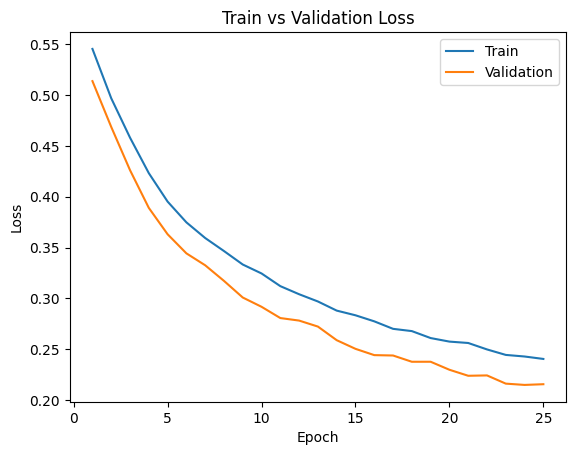

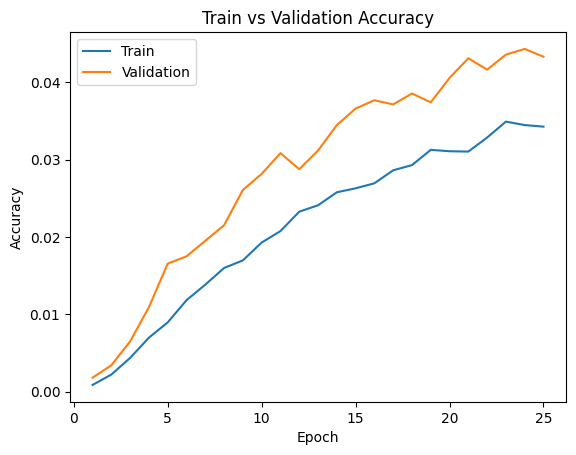

In [40]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

## CustomNet
Since the Transfer Learning for pretrained AlexNet with simple FC linear layer does not yield desiable result, our team decided to build a customNet inspired by AlexNet , but modified layer parameters and structures. 

In [52]:
#Custom Net Class
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 251, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=8, stride=4, padding=2),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.RReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.RReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [54]:
net = CustomNet()
net = net.to('cuda')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


trained_model, history = train_and_validate(net, epochs=10, batch_size = 64, lr=1e-4)

Epoch: 1/10


C:\Users\David\AppData\Local\Temp\ipykernel_8872\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 2.8624, Accuracy: 31.5723%, 
		Validation : Loss : 1.3266, Accuracy: 62.8344%, Time: 75.4834s
Epoch: 2/10
Epoch : 002, Training: Loss: 0.8709, Accuracy: 74.7117%, 
		Validation : Loss : 0.4969, Accuracy: 85.5534%, Time: 76.7194s
Epoch: 3/10
Epoch : 003, Training: Loss: 0.4027, Accuracy: 87.7948%, 
		Validation : Loss : 0.3568, Accuracy: 89.4416%, Time: 74.4500s
Epoch: 4/10
Epoch : 004, Training: Loss: 0.2529, Accuracy: 92.0812%, 
		Validation : Loss : 0.2783, Accuracy: 91.8415%, Time: 75.5804s
Epoch: 5/10
Epoch : 005, Training: Loss: 0.1837, Accuracy: 94.1146%, 
		Validation : Loss : 0.2845, Accuracy: 92.1700%, Time: 75.6030s
Epoch: 6/10
Epoch : 006, Training: Loss: 0.1416, Accuracy: 95.3284%, 
		Validation : Loss : 0.2457, Accuracy: 93.5577%, Time: 76.3066s
Epoch: 7/10
Epoch : 007, Training: Loss: 0.1158, Accuracy: 96.2399%, 
		Validation : Loss : 0.2853, Accuracy: 92.7599%, Time: 74.6577s
Epoch: 8/10
Epoch : 008, Training: Loss: 0.1003, Accuracy: 96.6900%

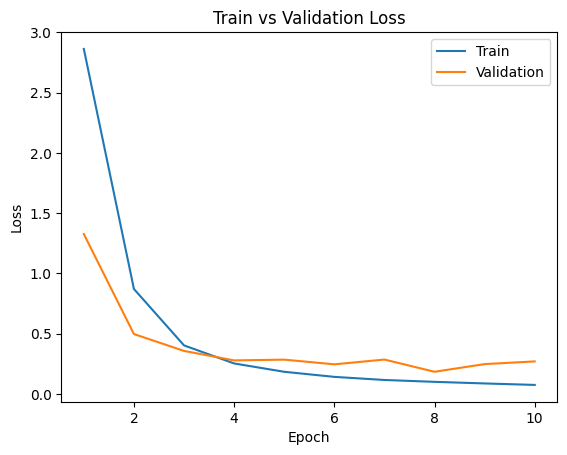

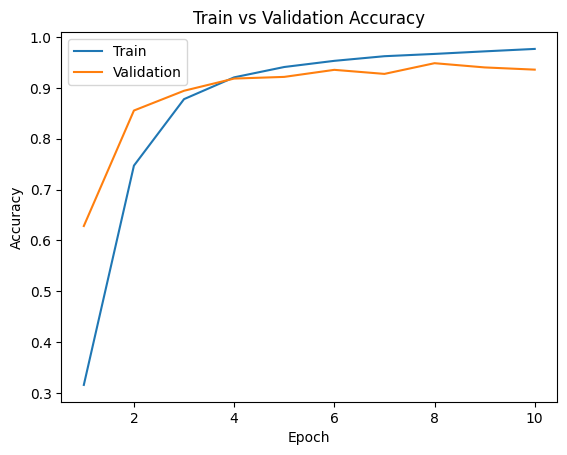

In [55]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

Custom Net Achieved signaficant better accuracy with only 10 epochs compared to the Transfer Learning AlexNet model at same number of epochs.Thus, out team decided to proceed with this model on celeb dataset that will be more close to proposed final application of the model.

In [61]:
#Saving the trained model
'''
path = r"C:\Users\David\clone\audio-speaker-recognition\notebooks\net.pth"
torch.save(net, path)
'''



In [65]:
'''
Load the pretrained CustomNet Model
'''
#Copy the full path of net.pth file
model = torch.load(r'\*Full path here*\')

In [83]:
model

CustomNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil

# FUTURE WORK
Transfer Learning the CustomNet model on test on celeb and voxceleb dataset.